In [41]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from LowLevelModules.GeneralFunctions import *
import numpy as np
import time
from LowLevelModules.LakeShore import LakeShore335
from pymeasure.instruments.keithley import Keithley2400
# keithley stuff
keithley = Keithley2400("GPIB0::24::INSTR")   # 'ASRL9::INSTR' if RS232 connection
keithley.apply_current()                # Sets up to source voltage
keithley.source_current_range = .01      # Sets the source voltage range to 1 V
keithley.compliance_voltage = 0.5      # Sets the compliance current to 1 mA
keithley.source_current = 0    
keithley.measure_voltage()              # Sets up to measure voltage

#lakeshore stuff
lakeshore = LakeShore335('GPIB0::12::INSTR')
lakeshore.set_target_temperature(5)
lakeshore.turn_heater_off()

In [42]:
FS_LABEL = 20
FS_TICKS = 18
class LivePlot2Vert:
    def __init__(self, x_ext=12, y_ext=6, mk='o', xlabel1='x1', ylabel1='y1', xlabel2='x2', ylabel2='y2'):
        self.fig = plt.figure(figsize=(x_ext, y_ext))
        self.ax1 = self.fig.add_subplot(211)
        plt.plot([], [], marker=mk)
        plt.xlabel(xlabel1, labelpad=10, fontsize=FS_LABEL)
        plt.ylabel(ylabel1, labelpad=10, fontsize=FS_LABEL)
        self.ax1.tick_params(axis='both', labelsize=FS_TICKS)

        self.ax2 = self.fig.add_subplot(212)
        plt.plot([], [], marker=mk)
        plt.xlabel(xlabel2, labelpad=10, fontsize=FS_LABEL)
        plt.ylabel(ylabel2, labelpad=10, fontsize=FS_LABEL)
        self.ax2.tick_params(axis='both', labelsize=FS_TICKS)

        self.fig.show()
        self.fig.canvas.draw()
        plt.tight_layout()

    def plot_live(self, xdata1, ydata1, xdata2, ydata2):
        self.ax1.lines[0].set_xdata(xdata1)
        self.ax1.lines[0].set_ydata(ydata1)
        self.ax1.relim()
        self.ax1.autoscale_view()

        self.ax2.lines[0].set_xdata(xdata2)
        self.ax2.lines[0].set_ydata(ydata2)
        self.ax2.relim()
        self.ax2.autoscale_view()

        self.fig.canvas.draw()
        plt.pause(1e-7)

<IPython.core.display.Javascript object>


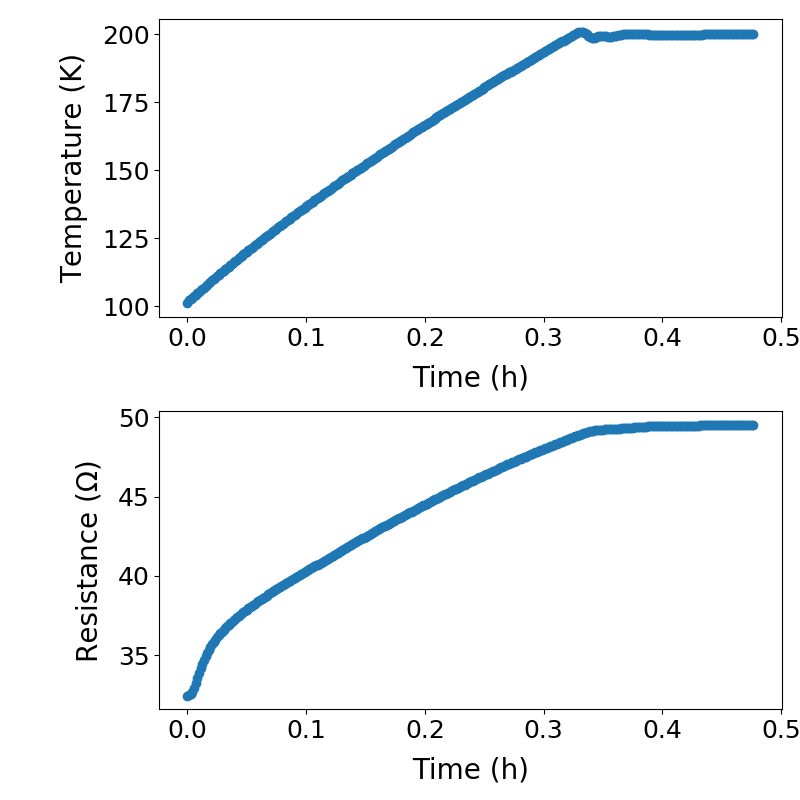

In [51]:
"""#######################################   USER INPUT   #################################################"""
save_data = True
collection_time = 5  #seconds

"""#########################################################################################################"""

# initialize the rest
lp = LivePlot2Vert(8, 8, 'o', 'Time (h)', 'Temperature (K)', 'Time (h)', 'Resistance (Ω)')
#lp.ax1.set_ylim([0, 300])
#lp.ax2.set_ylim([15, 65])
ti, Ta, Rs = [], [], []
t_now = 0

keithley.enable_source()
A = 0.001
keithley.ramp_to_current(A)                

while True:
    try:
        ti.append(t_now/3600)
        #measure the resistance
        Rs.append(keithley.voltage / A) 
        #measure the temperature
        Ta.append(lakeshore.get_temp("A"))
        print("T= "+ str(lakeshore.get_temp("A")) + " K.    R = ", keithley.voltage / A, end="\r")
        lp.plot_live(ti, Ta, ti, Rs)
        time.sleep(collection_time)
        t_now += collection_time
        #lp.ax1.legend(['Shield', 'Sample'], fontsize=20)

    except KeyboardInterrupt:
        break

keithley.disable_source()               

plt.show()
if save_data:
    data_type = 'Cryostat'
    data_header = "Time (hour)               Temp (K)                   Resistance (ohm)"
    data_array = np.array([ti, Ta, Rs]).T
    data_save(data_array, lp.fig, data_type, data_header)
    

In [6]:
keithley.shutdown()    

<IPython.core.display.Javascript object>


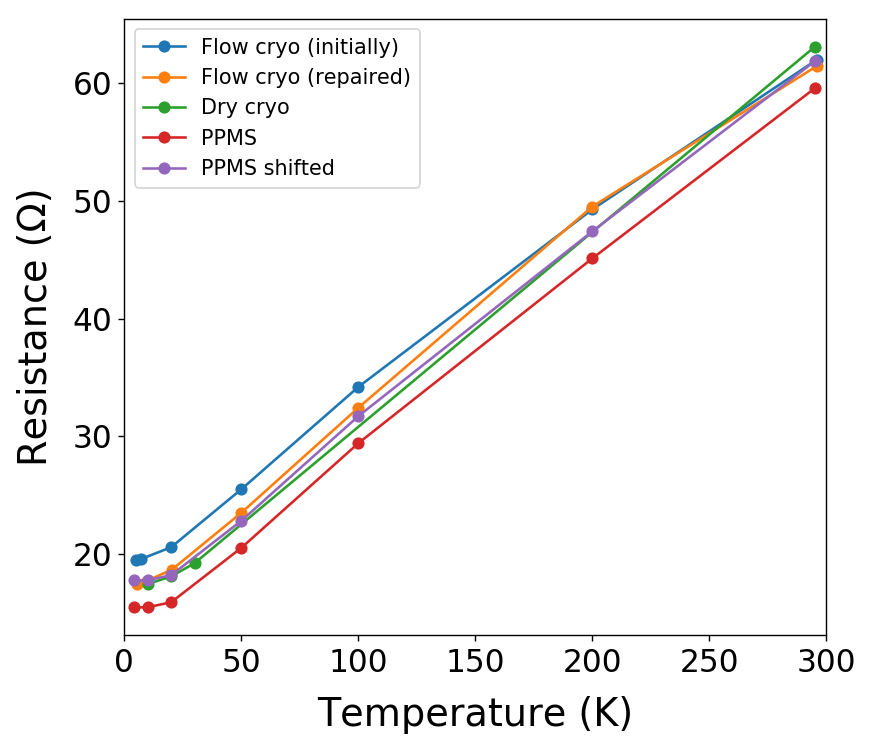

In [45]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from LowLevelModules.GeneralFunctions import *
import numpy as np

#Original temp calibration flow cryo
Temp = [5, 7, 20, 50, 100, 200, 296]
Res = [19.49, 19.55, 20.57, 25.5, 34.2, 49.3, 62.04]

# Re-calib data of flow cryo after repair (better thermal anchoring of RF line)
Temp_after_repair = [5.3, 9.7, 20.3, 50, 100, 200, 296]
Res_after_repair = [17.48, 17.71, 18.66, 23.5, 32.43, 49.54, 61.5]

#albert's data in dry cryo on same sample
T_calib = [10, 20, 30, 50, 70, 90, 120, 150, 180, 220, 260, 295]
R_calib = [17.438, 18.0835, 19.2077, 22.2651, 25.493, 28.5541, 32.9401, 37.2664, 41.5017, 46.9737, 52.46, 63.1214]
T_calib2 = [10, 20, 30, 295]
R_calib2 = [17.438, 18.0835, 19.2077, 63.1214]

#Varshith's data from new sample in PPMS
datapath = r"Z:\Projects\WSe2\2019\12 december\Gold_antenna_PPMS_Temp.dat"
data = np.genfromtxt(datapath, delimiter=',', skip_header=31, usecols=(3,6))
T_vars = data[:,0]
R_vars = data[:,1]
R_vars_shifted = [r+2.3 for r in R_vars]

#fitting
alpha = 0.0027
def res_vs_temp(T):
    return 59.6 * (1 + alpha*(T-295))
T_fit = np.arange(0, 300)
R_fit = res_vs_temp(T_fit)

#plotting
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111)
#ax.plot(T_fit, R_fit, 'r-')
ax.plot(Temp, Res, 'o-', label='Flow cryo (initially)')
ax.plot(Temp_after_repair, Res_after_repair, 'o-', label='Flow cryo (repaired)')
ax.plot(T_calib2, R_calib2, 'o-', label='Dry cryo')
ax.plot(T_vars, R_vars, 'o-', label='PPMS')
ax.plot(T_vars, R_vars_shifted, 'o-', label='PPMS shifted')
prettify_plot(ax, "Temperature (K)", "Resistance (Ω)")
ax.set_xlim([0, 300])
ax.legend(fontsize=12)
plt.tight_layout()

In [33]:
(1 - 15.45/59.6)/295

0.0025110908884085994

In [36]:
1/295

0.003389830508474576